# Compare docking strategies

This notebook explores and visualizes the performance of the docking algorithms **Fred**, **Hybrid** and **Posit**. Additionally, a Posit experiment is included, in which the most similar co-crystallized ligand from all available kinase structures in the same conformation is transferred to bias the docking algorithm.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)
posit_template_results = pd.read_csv("../data/posit_template_results.csv", index_col=0)

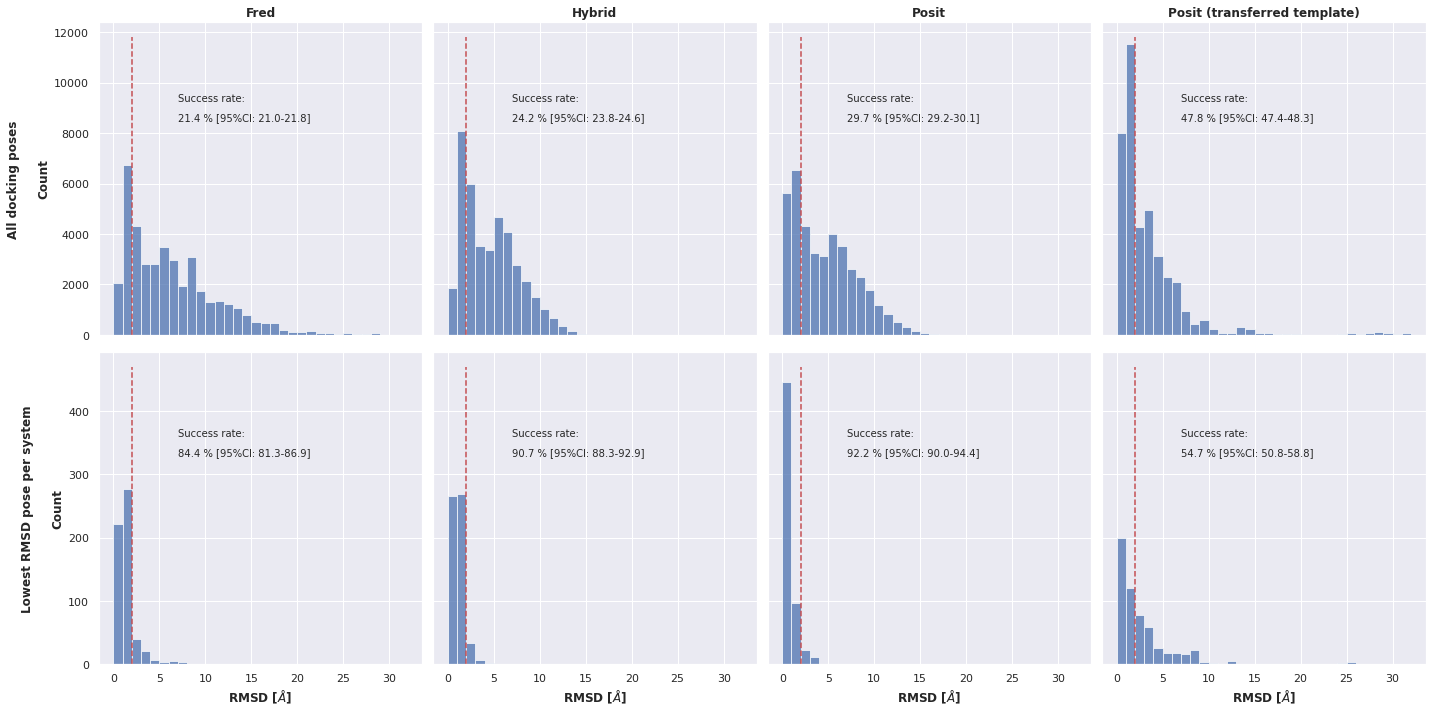

In [5]:
def plot_performance(fred_results, hybrid_results, posit_results, posit_template_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]    
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 6 subplots
    fig, axes = plt.subplots(2, 4, sharey='row', sharex=True, figsize=(20, 10))
    
    # plot data
    bins = range(
        0, 
        int(max(
            fred_results["rmsd"].max(), 
            hybrid_results["rmsd"].max(), 
            posit_results["rmsd"].max(),
            posit_template_results["rmsd"].max(),
        )), 
        1
    )
    sns.histplot(data=fred_results, x="rmsd", bins=bins, ax=axes[0][0])
    sns.histplot(data=hybrid_results, x="rmsd", bins=bins, ax=axes[0][1])
    sns.histplot(data=posit_results, x="rmsd", bins=bins, ax=axes[0][2])
    sns.histplot(data=posit_template_results, x="rmsd", bins=bins, ax=axes[0][3])
    
    # titles
    axes[0][0].set_title("Fred", fontweight="bold")
    axes[0][1].set_title("Hybrid", fontweight="bold")
    axes[0][2].set_title("Posit", fontweight="bold")
    axes[0][3].set_title("Posit (transferred template)", fontweight="bold")
    
    # axes and 2 A cutoff
    axes[0][0].set_ylabel("All docking poses\n\nCount", fontweight="bold")
    for i in range(4):
        axes[0][i].set_xlabel("")
        axes[0][i].vlines(2, ymin=0, ymax=11800, colors="r", linestyles="dashed")
    
    # sort by rmsd and pick the lowest RMSD pose per system
    fred_results_best = fred_results.sort_values("rmsd")
    fred_results_best = fred_results_best.groupby(["ligand_pdb_id"]).head(1)
    hybrid_results_best = hybrid_results.sort_values("rmsd")
    hybrid_results_best = hybrid_results_best.groupby(["ligand_pdb_id"]).head(1)
    posit_results_best = posit_results.sort_values("rmsd")
    posit_results_best = posit_results_best.groupby(["ligand_pdb_id"]).head(1)
    posit_template_results_best = posit_template_results.sort_values("rmsd")
    posit_template_results_best = posit_template_results_best.groupby(["ligand_pdb_id"]).head(1)
    
    # plot data
    sns.histplot(data=fred_results_best, x="rmsd", bins=bins, ax=axes[1][0])
    sns.histplot(data=hybrid_results_best, x="rmsd", bins=bins, ax=axes[1][1])
    sns.histplot(data=posit_results_best, x="rmsd", bins=bins, ax=axes[1][2])
    sns.histplot(data=posit_template_results_best, x="rmsd", bins=bins, ax=axes[1][3])
    
    # axes and 2 A cutoff
    axes[1][0].set_ylabel("Lowest RMSD pose per system\n\nCount", fontweight="bold")
    for i in range(4):
        axes[1][i].set_xlabel("RMSD [$\AA$]", fontweight="bold")
        axes[1][i].vlines(2, ymin=0, ymax=470, colors="r", linestyles="dashed")
    
    # bootstrapping for confidence intervals
    sampled_success_rates = []
    for i, (method, results) in enumerate(zip(
        ["Fred", "Hybrid", "Posit", "Posit (transferred template)"], 
        [fred_results, hybrid_results, posit_results, posit_template_results]
    )):
        for j, focus in enumerate(["All docking poses", "Lowest RMSD pose per system"]):
            sampled_success_rates_i = []
            if focus == "All docking poses":
                success_labels = (results["rmsd"] <= 2).to_list()
            elif focus == "Lowest RMSD pose per system":
                selected_results = results.sort_values("rmsd")
                selected_results = selected_results.groupby(["ligand_pdb_id"]).head(1)
                success_labels = (selected_results["rmsd"] <= 2).to_list()
            for _ in range(n_bootstrap):
                sampled_success_labels = resample(success_labels, replace=True)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates.append([
                method,
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            ys = [9250, 8525]
            if j == 1:
                ys = [360, 330]
            axes[j][i].annotate(
                "Success rate:", 
                xy=(7, ys[0]),
                fontsize=10,
            )
            axes[j][i].annotate(
                f"{success_rate_mean:.1f} % [95%CI: {ci_lower_bound:.1f}-{ci_upper_bound:.1f}]", 
                xy=(7, ys[1]),
                fontsize=10,
            )
    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, columns=["method", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    
    plt.tight_layout()
    plt.savefig(directory / "docking_performance.pdf", dpi=300)
    
    return sampled_success_rates


sampled_success_rates = plot_performance(fred_results, hybrid_results, posit_results, posit_template_results)

In [6]:
sampled_success_rates

,method,focus,success_rate,ci_lower,ci_upper
0,Fred,All docking poses,21.423970,21.045205,21.811591
1,Fred,Lowest RMSD pose per system,84.419525,81.324278,86.926995
2,Hybrid,All docking poses,24.227765,23.808363,24.610508
3,Hybrid,Lowest RMSD pose per system,90.687436,88.285229,92.869270
4,Posit,All docking poses,29.657551,29.203238,30.132144
5,Posit,Lowest RMSD pose per system,92.168081,89.983022,94.397284
6,Posit (transferred template),All docking poses,47.813645,47.357614,48.332926
7,Posit (transferred template),Lowest RMSD pose per system,54.727768,50.766610,58.773424
